#Binary Classifier(How to improve it)

Outline:
1. Training Binary classifier for IMDB review dataset
2. Training Binary classifier for sarcasm dataset
3. Subwords Tokenization with IMDB review Dataset
4. Subword Text Encoding and training the model using it

##Training a binary classifier with the IMDB Reviews Dataset

Here, we will be building a sentiment classification model to distinguish between positive and negative movie reviews. We will train it on the IMDB Reviews dataset and visualize the word embeddings generated after training.

###Download the Dataset

First, we need to fetch the dataset. This is hosted via Tensorflow Datasets, a collection of prepared datasets for machine learning.

In [ ]:
import tensorflow_datasets as tfds

# Load the IMDB Reviews dataset
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteREK7FC/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteREK7FC/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteREK7FC/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
#Information about the dataset
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path=PosixGPath('/tmp/tmpcbmg68wqtfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInf

There is a total of 100,000 examples in the dataset and it is split into train, test and unsupervised sets.

###Split the dataset


In [ ]:
#contents of the dataset we downloaded
print(imdb)

{Split('train'): <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('test'): <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('unsupervised'): <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


We can preview the raw format of a few examples by using the take() method and iterating over it as shown below:


In [ ]:
# Take 2 training examples and print its contents
for example in imdb['train'].take(2):
  print(example)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on

We can see that each example is a 2-element tuple of tensors containing the text first, then the label (shown in the numpy() property). The next cell below will take all the train and test sentences and labels into separate lists so we can preprocess the text and feed it to the model later.

In [ ]:
import numpy as np

# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

###Generate Padded Sequences

Now we can do the text preprocessing steps. We will tokenize the sentences and pad them to a uniform length. 

In [ ]:
# Parameters
vocab_size = 10000
max_length = 120
embedding_dim = 16
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type)

###Build and Compile the Model

With the data already preprocessed, we can proceed to building our sentiment classification model. The input will be an Embedding layer. The main idea here is to represent each word in our vocabulary with vectors. These vectors have trainable weights so as our neural network learns, words that are most likely to appear in a positive tweet will converge towards similar weights. Similarly, words in negative tweets will be clustered more closely together. 

After the Embedding layer, we will flatten its output and feed it into a Dense layer.

The output layer would be a single neuron with a sigmoid activation to distinguish between the 2 classes. As is typical with binary classifiers, we will use the binary_crossentropy as our loss function while training.

In [ ]:
import tensorflow as tf

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


###Train the Model

Next, we train our model. 

In [ ]:
num_epochs = 10

# Train the model
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 5s 5ms/step - loss: 0.5115 - accuracy: 0.7155 - val_loss: 0.3816 - val_accuracy: 0.8302
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2499 - accuracy: 0.9022 - val_loss: 0.4007 - val_accuracy: 0.8246
Epoch 3/10
782/782 [==============================] - 5s 7ms/step - loss: 0.1024 - accuracy: 0.9716 - val_loss: 0.4989 - val_accuracy: 0.8056
Epoch 4/10
782/782 [==============================] - 4s 6ms/step - loss: 0.0252 - accuracy: 0.9966 - val_loss: 0.6071 - val_accuracy: 0.8030
Epoch 5/10
782/782 [==============================] - 4s 6ms/step - loss: 0.0064 - accuracy: 0.9994 - val_loss: 0.6786 - val_accuracy: 0.8050
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.7337 - val_accuracy: 0.8066
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 9.0099e-04 - accuracy: 1.0000 - val_loss: 0.7828 - val_accuracy: 0.8087
Ep

###Visualize Word Embeddings

After training, we can visualize the trained weights in the Embedding layer to see words that are clustered together. The Tensorflow Embedding Projector is able to reduce the 16-dimension vectors we defined earlier into fewer components so it can be plotted in the projector. First, we will need to get these weights and you can do that with the cell below:

In [ ]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

(10000, 16)


We need to generate two files:

* vecs.tsv - contains the vector weights of each word in the vocabulary
* meta.tsv - contains the words in the vocabulary

For this, it is useful to have reverse_word_index dictionary so we can quickly lookup a word based on a given index. For example, reverse_word_index[1] will return your OOV token because it is always at index = 1. 

In [ ]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

In [ ]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [ ]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now we can go to the Tensorflow Embedding Projector 'https://projector.tensorflow.org/' and load the two files we downloaded to see the visualization. We can search for words like worst and fantastic and see the other words closely located to these.

##Training a binary classifier with the Sarcasm Dataset

Here we will visit the News Headlines Dataset for Sarcasm Detection and proceed to build a train a model on it. The steps will be very similar to the previous model with IMDB Reviews with just some minor modifications.

###Download the dataset

We will first download the JSON file, load it into your workspace and put the sentences and labels into lists.


In [ ]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-01-29 15:52:44--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 173.194.218.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2023-01-29 15:52:44 (146 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [ ]:
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

###Hyperparameters


In [ ]:
# Number of examples to use for training
training_size = 20000

# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 32

# Output dimensions of the Embedding layer
embedding_dim = 16

###Split the dataset
Next, we will generate your train and test datasets. 

In [ ]:
# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

###Preprocessing the train and test sets

Now we can preprocess the text and labels so it can be consumed by the model. We use the Tokenizer class to create the vocabulary and the pad_sequences method to generate padded token sequences. We will also need to set the labels to a numpy array so it can be a valid data type for model.fit().


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

###Build and Compile the Model

Next, we will build the model. The architecture is similar to the previous model but we will use a GlobalAveragePooling1D layer instead of Flatten after the Embedding. This adds the task of averaging over the sequence dimension before connecting to the dense layers. 

See a short demo of how this works using the snippet below. 

Notice that it gets the average over 3 arrays (i.e. (10 + 1 + 1) / 3 and (2 + 3 + 1) / 3 to arrive at the final output.

In [ ]:
import tensorflow as tf
import numpy as np

# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


This added computation reduces the dimensionality of the model as compared to using Flatten() and thus, the number of training parameters will also decrease. 

See the output of model.summary() below and see how it compares if you swap out the pooling layer with a simple Flatten().



In [ ]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

###Train the Model

Now we will feed in the prepared datasets to train the model. If you used the default hyperparameters, we will get around 99% training accuracy and 80% validation accuracy.

Tip: We can set the verbose parameter of model.fit() to 2 to indicate that we want to print just the results per epoch. Setting it to 1 (default) displays a progress bar per epoch, while 0 silences all displays. 



In [ ]:
num_epochs = 30

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.5672 - accuracy: 0.6971 - val_loss: 0.3954 - val_accuracy: 0.8357 - 3s/epoch - 5ms/step
Epoch 2/30
625/625 - 2s - loss: 0.3102 - accuracy: 0.8743 - val_loss: 0.3443 - val_accuracy: 0.8548 - 2s/epoch - 3ms/step
Epoch 3/30
625/625 - 2s - loss: 0.2318 - accuracy: 0.9095 - val_loss: 0.3447 - val_accuracy: 0.8566 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 2s - loss: 0.1856 - accuracy: 0.9292 - val_loss: 0.3787 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 5/30
625/625 - 2s - loss: 0.1543 - accuracy: 0.9442 - val_loss: 0.3966 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1309 - accuracy: 0.9531 - val_loss: 0.4357 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1106 - accuracy: 0.9617 - val_loss: 0.4725 - val_accuracy: 0.8439 - 2s/epoch - 3ms/step
Epoch 8/30
625/625 - 2s - loss: 0.0956 - accuracy: 0.9675 - val_loss: 0.5170 - val_accuracy: 0.8375 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 2s 

###Visualize the Results
You can use the cell below to plot the training results. You may notice some overfitting because your validation accuracy is slowly dropping while the training accuracy is still going up. See if you can improve it by tweaking the hyperparameters. Some example values are shown in the lectures.



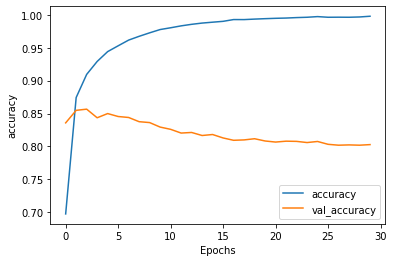

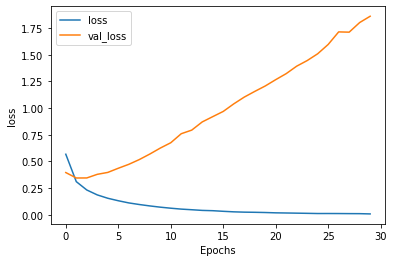

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

###Visualize Word Embeddings
As before, we can visualize the final weights of the embeddings using the Tensorflow Embedding Projector.



In [ ]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

(10000, 16)


In [ ]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [ ]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Subword Tokenization with the IMDB Reviews Dataset

Here, we will look at a pre-tokenized dataset that is using subword text encoding. This is an alternative to word-based tokenization which we have been using in the previous model. We will see how it works and its implications on preparing our data and training our model.

Download the IMDB reviews plain text and tokenized datasets
First, we will download the IMDB Reviews dataset from Tensorflow Datasets. We will get two configurations:

* plain_text - this is the default and the one we used in model 1 of this notebook
* subwords8k - a pre-tokenized dataset (i.e. instead of sentences of type string, it will already give us the tokenized sequences). 


In [ ]:
import tensorflow_datasets as tfds

# Download the plain text default config
imdb_plaintext, info_plaintext = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Download the subword encoded pretokenized dataset
imdb_subwords, info_subwords = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4XCK4H/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4XCK4H/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4XCK4H/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXQ3BD7/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXQ3BD7/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXQ3BD7/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


###Compare the two datasets

The data types returned by the two datasets will be different. For the default, it will be strings as we also saw in Model 1. 


In [ ]:
# Print description of features
info_plaintext.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(), dtype=string),
})

In [ ]:

# Take 2 training examples and print the text feature
for example in imdb_plaintext['train'].take(2):
  print(example[0].numpy())


b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was

For subwords8k, the dataset is already tokenized so the data type will be integers. Notice that the text features also include an encoder field and has a vocab_size of around 8k, hence the name.


In [ ]:
# Print description of features
info_subwords.features


FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(None,), dtype=int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

If we print the results, we will not see string sentences but a sequence of tokens:


In [ ]:
# Take 2 training examples and print its contents
for example in imdb_subwords['train'].take(2):
  print(example)


(<tf.Tensor: shape=(163,), dtype=int64, numpy=
array([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
       5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
          3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
         79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
         33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
         27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
         19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
        102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
          3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
          2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
        102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
         27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
         12,  258, 2306,   13,   91,   29,  171,   52,  229,    2, 1245,
    

We can get the encoder object included in the download and use it to decode the sequences above. We'll see that we will arrive at the same sentences provided in the plain_text config:


In [ ]:
# Get the encoder
tokenizer_subwords = info_subwords.features['text'].encoder

# Take 2 training examples and decode the text feature
for example in imdb_subwords['train'].take(2):
  print(tokenizer_subwords.decode(example[0]))


This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was cons

##Subword Text Encoding and Traing the model using it

From previous imdb model, the number of tokens in the sequence is the same as the number of words in the text (i.e. word tokenization). The following cells shows a review of this process.

In [ ]:
# Get the train set
train_data = imdb_plaintext['train']

# Initialize sentences list
training_sentences = []

# Loop over all training examples and save to the list
for s,_ in train_data:
  training_sentences.append(s.numpy().decode('utf8'))

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
oov_tok = '<OOV>'

# Initialize the Tokenizer class
tokenizer_plaintext = Tokenizer(num_words = 10000, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer_plaintext.fit_on_texts(training_sentences)

# Generate the training sequences
sequences = tokenizer_plaintext.texts_to_sequences(training_sentences)

The cell above uses a vocab_size of 10000 but we'll find that it's easy to find OOV tokens when decoding using the lookup dictionary it created. 
See the result below:



In [ ]:
# Decode the first sequence using the Tokenizer class
tokenizer_plaintext.sequences_to_texts(sequences[0:1])

["this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor's like christopher <OOV> good name i could barely sit through it"]

For binary classifiers, this might not have a big impact but we may have other applications that will benefit from avoiding OOV tokens when training the model (e.g. text generation). 

If we want the tokenizer above to not have OOVs, then the vocab_size will increase to more than 88k. This can slow down training and bloat the model size. The encoder also won't be robust when used on other datasets which may contain new words, thus resulting in OOVs again.

In [ ]:
# Total number of words in the word index dictionary
len(tokenizer_plaintext.word_index)

88583

Subword text encoding gets around this problem by using parts of the word to compose whole words. This makes it more flexible when it encounters uncommon words. See how these subwords look like for this particular encoder:


In [ ]:
# Print the subwords
print(tokenizer_subwords.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

If we use it on the previous plain text sentence, we'll see that it won't have any OOVs even if it has a smaller vocab size (only 8k compared to 10k above):


In [ ]:

# Encode the first plaintext sentence using the subword text encoder
tokenized_string = tokenizer_subwords.encode(training_sentences[0])
print(tokenized_string)

# Decode the sequence
original_string = tokenizer_subwords.decode(tokenized_string)

# Print the result
print (original_string)

[62, 18, 41, 604, 927, 65, 3, 644, 7968, 21, 35, 5096, 36, 11, 43, 2948, 5240, 102, 50, 681, 7862, 1244, 3, 3266, 29, 122, 640, 2, 26, 14, 279, 438, 35, 79, 349, 384, 11, 1991, 3, 492, 79, 122, 188, 117, 33, 4047, 4531, 14, 65, 7968, 8, 1819, 3947, 3, 62, 27, 9, 41, 577, 5044, 2629, 2552, 7193, 7961, 3642, 3, 19, 107, 3903, 225, 85, 198, 72, 1, 1512, 738, 2347, 102, 6245, 8, 85, 308, 79, 6936, 7961, 23, 4981, 8044, 3, 6429, 7961, 1141, 1335, 1848, 4848, 55, 3601, 4217, 8050, 2, 5, 59, 3831, 1484, 8040, 7974, 174, 5773, 22, 5240, 102, 18, 247, 26, 4, 3903, 1612, 3902, 291, 11, 4, 27, 13, 18, 4092, 4008, 7961, 6, 119, 213, 2774, 3, 12, 258, 2306, 13, 91, 29, 171, 52, 229, 2, 1245, 5790, 995, 7968, 8, 52, 2948, 5240, 8039, 7968, 8, 74, 1249, 3, 12, 117, 2438, 1369, 192, 39, 7975]
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not re

Subword encoding can even perform well on words that are not commonly found on movie reviews. See first the result when using the plain text tokenizer. As expected, it will show many OOVs:


In [ ]:

# Define sample sentence
sample_string = 'TensorFlow, from basics to mastery'

# Encode using the plain text tokenizer
tokenized_string = tokenizer_plaintext.texts_to_sequences([sample_string])
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the result
original_string = tokenizer_plaintext.sequences_to_texts(tokenized_string)
print ('The original string: {}'.format(original_string))

Tokenized string is [[1, 37, 1, 6, 1]]
The original string: ['<OOV> from <OOV> to <OOV>']


Then compare to the subword text encoder:

In [ ]:
# Encode using the subword text encoder
tokenized_string = tokenizer_subwords.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the results
original_string = tokenizer_subwords.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


As we may notice, the sentence is correctly decoded. The downside is the token sequence is much longer. Instead of only 5 when using word-encoding, we ended up with 11 tokens instead. The mapping for this sentence is shown below:


In [ ]:
# Show token to subword mapping:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_subwords.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


###Training the model
We will now train our model using this pre-tokenized dataset. Since these are already saved as sequences, we can jump straight to making uniform sized arrays for the train and test sets. These are also saved as tf.data.Dataset type so we can use the padded_batch() method to create batches and pad the arrays into a uniform size for training.


In [ ]:

BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Get the train and test splits
train_data, test_data = imdb_subwords['train'], imdb_subwords['test'], 

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

Next, we will build the model. We can just use the architecture from the previous model.


In [ ]:
import tensorflow as tf

# Define dimensionality of the embedding
embedding_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer_subwords.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


Similarly, we can use the same parameters for training.


In [ ]:
num_epochs = 10

# Set the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Start training
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 17s 39ms/step - loss: 0.6729 - accuracy: 0.6005 - val_loss: 0.6134 - val_accuracy: 0.7858
Epoch 2/10
391/391 [==============================] - 14s 35ms/step - loss: 0.4981 - accuracy: 0.8124 - val_loss: 0.4324 - val_accuracy: 0.8274
Epoch 3/10
391/391 [==============================] - 14s 34ms/step - loss: 0.3465 - accuracy: 0.8798 - val_loss: 0.3468 - val_accuracy: 0.8663
Epoch 4/10
391/391 [==============================] - 13s 32ms/step - loss: 0.2832 - accuracy: 0.8982 - val_loss: 0.3179 - val_accuracy: 0.8770
Epoch 5/10
391/391 [==============================] - 13s 32ms/step - loss: 0.2450 - accuracy: 0.9114 - val_loss: 0.3096 - val_accuracy: 0.8786
Epoch 6/10
391/391 [==============================] - 13s 32ms/step - loss: 0.2233 - accuracy: 0.9196 - val_loss: 0.3140 - val_accuracy: 0.8730
Epoch 7/10
391/391 [==============================] - 13s 32ms/step - loss: 0.2050 - accuracy: 0.9252 - val_loss: 0.3128 - val_accuracy:

###Visualize the results
We can use the cell below to plot the training results.


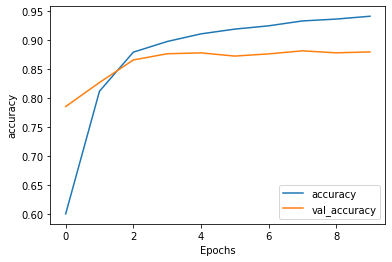

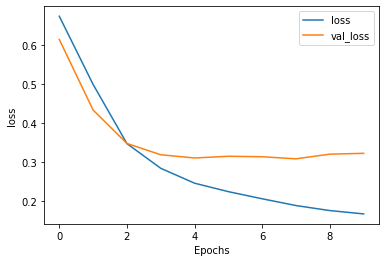

In [ ]:

import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

While Earlier we got a validation accuracy of 80%, here by using pre tokenized data we increased the validfation accuracy to 88%